**FIRST ATTEMP TO APPLY SSL TO THE SENTINEL-2 DATASET**

Reference tutorial: https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html

In [1]:
%load_ext pycodestyle_magic

In [2]:
%pycodestyle_on

In [3]:
# Reproducibility.
SEED = 42

***

***

# Split the dataset folder

## Ratio (imbalanced)

## Ratio to create reduced sample

## Fixed (balanced)

***

***

# Imports

## Libraries and modules

In [4]:
import os

import torch
import torchvision

from torchinfo import summary

import lightly
from lightly.models.modules.heads import SimSiamPredictionHead
from lightly.models.modules.heads import SimSiamProjectionHead
from lightly.utils.debug import std_of_l2_normalized
import copy

import matplotlib.pyplot as plt
import numpy as np
import math
import random

# Training checks.
import time
from datetime import datetime

# Showing images in the notebook.
import IPython
# from IPython.display import Image
# from IPython.core.display import HTML

# For plotting.
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# For resizing images to thumbnails.
import torchvision.transforms.functional as functional

# For clustering and 2d representations-
from sklearn import random_projection

## Settings

In [5]:
# Training on GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Hyperparamenters.
input_size = 224  # old_input_size = 256
batch_size = 128   # old_batch_size = 128
num_workers = 8

EPOCHS = 5

# Dimension of the embeddings.
num_ftrs = 512

# Dimension of the output of the prediction and projection heads.
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture.
pred_hidden_dim = 128

## Reproducibility

In [7]:
# Seed torch and numpy.
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Enable CUDNN deterministic mode.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Issues a warning if it is not met.
torch.use_deterministic_algorithms(True)

In [8]:
# For dataloaders.
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

In [9]:
# Enable deterministic behavior using external GPU.
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

***

***

# Loading dataset

In [10]:
data_dir_target = 'datasets/Sentinel2GlobalLULC_full_ratio_seed=' \
                  + str(SEED)

## Custom tranforms (w/o normalization)

Define the augmentations for self-supervised learning.

In [11]:
# Data augmentations for the train dataset.
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.RandomResizedCrop(size=input_size,
                                             scale=(0.2, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.GaussianBlur(21),
    torchvision.transforms.ToTensor(),
])

# Data augmentations for the val and test datasets.
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
])

## ImageFolder

In [12]:
# Loading the three datasets.
train_data = torchvision.datasets.ImageFolder(data_dir_target + '/train/')

val_data = torchvision.datasets.ImageFolder(data_dir_target + '/val/')

test_data = torchvision.datasets.ImageFolder(data_dir_target + '/test/')

# Building the lightly datasets from the PyTorch datasets.
train_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(train_data)

val_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(
    val_data,
    transform=test_transform
)

test_data_lightly = lightly.data.LightlyDataset.from_torch_dataset(
    test_data,
    transform=test_transform
)

## Collate functions

PyTorch uses a Collate Function to combine the data in your batches together.

BaseCollateFunction (base class) takes a batch of images as input and transforms each image into two different augmentations with the help of random transforms. The images are then concatenated such that the output batch is exactly twice the length of the input batch.

In [13]:
# Base class for other collate implementations.
# This allows training.
collate_fn_train = lightly.data.collate.BaseCollateFunction(train_transform)

## PyTorch dataloaders

In [14]:
# Dataloader for training.
dataloader_train_simsiam = torch.utils.data.DataLoader(
    train_data_lightly,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_train,
    drop_last=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for embedding (val).
dataloader_val = torch.utils.data.DataLoader(
    val_data_lightly,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Dataloader for embedding (test).
dataloader_test = torch.utils.data.DataLoader(
    test_data_lightly,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

## Check the balance and size of the dataset

In [15]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([9800, 3259, 6208, 9800, 8355, 3105,  943, 9800, 7306, 4466, 2015,
        396,  880, 9800, 2739, 2710, 9793,  291,  340, 2943, 9800, 9800,
       9800, 1402,  589,  714,  247,  289, 8813]))


In [16]:
# Check samples per class in train dataset.
print(np.unique(val_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([1400,  465,  886, 1400, 1193,  443,  134, 1400, 1043,  638,  288,
         56,  125, 1400,  391,  387, 1399,   41,   48,  420, 1400, 1400,
       1400,  200,   84,  102,   35,   41, 1259]))


In [17]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]), array([2800,  932, 1775, 2800, 2389,  889,  271, 2800, 2089, 1276,  577,
        115,  253, 2800,  784,  775, 2799,   84,   99,  842, 2800, 2800,
       2800,  402,  169,  204,   71,   83, 2518]))


In [18]:
print('N batches in train dataset: ' + str(len(dataloader_train_simsiam)))

# Check the size of each dataset.
print(len(train_data.targets))
print(len(val_data.targets))
print(len(test_data.targets))

N batches in train dataset: 1065
136403
19478
38996


## See some samples (lightly dataset)

torch.Size([128, 3, 224, 224])
torch.Size([128])


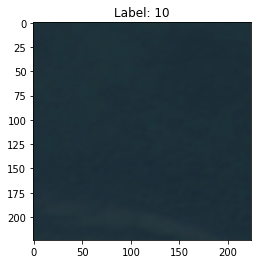

In [19]:
# Accessing Data and Targets in a PyTorch DataLoader.
for images, labels, names in dataloader_train_simsiam:
    img = images[0][0]
    label = labels[0]
    print(images[0].shape)
    print(labels.shape)
    plt.title("Label: " + str(int(label)))
    plt.imshow(torch.permute(img, (1, 2, 0)))
    plt.show()
    break  # Only one batch.

# SimSiam model

In [20]:
IPython.display.Image(
    url="https://user-images.githubusercontent.com/"
    "2420753/118343499-4c410100-b4de-11eb-9313-d49e65440a7e.png",
    width=700,
    height=700)

Given an image, we create two augmented views and process these two versions with the same encoder network (a backbone plus a projection MLP).

The predictor is another MLP and on the other side a stop-gradient operation is applied. And we maximize the similarity at the end.

## Creation

In [21]:
# Copied from the reference tutorial.
class SimSiam(torch.nn.Module):

    # Constructor.
    def __init__(self, backbone, num_ftrs, proj_hidden_dim,
                 pred_hidden_dim, out_dim):

        # Inheritance.
        super().__init__()

        # Blackbone model.
        self.backbone = backbone

        # Projection head (lightly).
        self.projection_head = SimSiamProjectionHead(
            num_ftrs, proj_hidden_dim, out_dim)

        # Prediction head (lightly).
        self.prediction_head = SimSiamPredictionHead(
            out_dim, pred_hidden_dim, out_dim)

    # In the forward function, you define how your model
    # is going to be run, from input to output.
    def forward(self, x):

        # Get representations.
        f = self.backbone(x).flatten(start_dim=1)

        # Get projections.
        z = self.projection_head(f)

        # Get predictions.
        p = self.prediction_head(z)

        # Stop gradient.
        z = z.detach()

        return z, p

## Backbone net (w/ ResNet18)

This is different from the tutorial: resnet without pretrained weights (not now).

In [22]:
# Resnet trained from scratch.
resnet = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)

# Removing head from resnet. Embedding.
backbone = torch.nn.Sequential(*list(resnet.children())[:-1])

# Model creation.
model = SimSiam(backbone, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim)

In [23]:
# Model's backbone structure.
summary(
    model.backbone,
    input_size=(batch_size, 3, input_size, input_size),
    device=device
)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 512, 1, 1]          --
├─Conv2d: 1-1                            [128, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [128, 64, 112, 112]       128
├─ReLU: 1-3                              [128, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [128, 64, 56, 56]         --
├─Sequential: 1-5                        [128, 64, 56, 56]         --
│    └─BasicBlock: 2-1                   [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-1                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-3                    [128, 64, 56, 56]         --
│    │    └─Conv2d: 3-4                  [128, 64, 56, 56]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 56, 56]         128
│    │    └─ReLU: 3-6                    [128, 64, 56, 56]         --
│

## Training setup

SimSiam uses a symmetric negative cosine similarity loss and does therefore not require any negative samples. We build a criterion and an optimizer.



In [24]:
# SimSiam uses a symmetric negative cosine similarity loss.
criterion = lightly.loss.NegativeCosineSimilarity()

# Scale the learning rate.
lr = 0.05 * batch_size / 256

# Use SGD with momentum and weight decay.
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=5e-4
)

## Training

### Loop

In [29]:
print(f"Using {device} device")
model.to(device)

# Setup.
avg_loss = 0.
avg_output_std = 0.
avg_rep_collapse = 0.

# Saving best model's weights.
best_model_wts = copy.deepcopy(model.state_dict())
lowest_loss = 10000
lowest_collapse_level = 10000

# Main training loop.
for e in range(EPOCHS):

    # Timer added.
    t0 = time.time()

    batch_id = 0

    # Iterating through the dataloader (lightly dataset is different).
    for (x0, x1), _, _ in dataloader_train_simsiam:

        # Move images to the GPU.
        x0 = x0.to(device)
        x1 = x1.to(device)

        # Run the model on both transforms of the images:
        # We get projections (z0 and z1) and
        # predictions (p0 and p1) as output.
        z0, p0 = model(x0)
        z1, p1 = model(x1)

        # Apply the symmetric negative cosine similarity
        # and run backpropagation.
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # Calculate the per-dimension standard deviation of the outputs.
        # We can use this later to check whether the embeddings are collapsing.
        output = p0.detach()
        output = torch.nn.functional.normalize(output, dim=1)

        output_std = torch.std(output, 0)
        output_std = output_std.mean()

        # Use moving averages to track the loss and standard deviation.
        w = 0.9
        avg_loss = w * avg_loss + (1 - w) * loss.item()
        avg_output_std = w * avg_output_std + (1 - w) * output_std.item()

        # Use moving averages to track representation collapse.
        avg_rep_collapse = (w * avg_rep_collapse
                            + (1 - w) * std_of_l2_normalized(output).item())

        if batch_id % 50 == 49:
            print(f'T[{e + 1}, {batch_id + 1:5d}] | '
                  f'Loss: {avg_loss:.4f} | '
                  f'Representation std: {avg_rep_collapse:.4f}')

        batch_id += 1

    # The level of collapse is large if the standard deviation of the L2
    # normalized output is much smaller than 1 / sqrt(dim).
    collapse_level = max(0., 1 - math.sqrt(out_dim) * avg_output_std)

    # Ideal value for not collapsing.
    rep_ideal = 1 / math.sqrt(out_dim)

    # Deep copy the weights of the model.
    save_model = True
    if save_model:
        lowest_loss = avg_loss
        lowest_collapse_level = collapse_level
        lowest_rep_collapse = avg_rep_collapse
        best_model_wts = copy.deepcopy(model.state_dict())

        # Move to CPU before saving it.
        model.to('cpu')

        # Filename with stats.
        filename = f'pytorch_models/simsiam/simsiam_backbone_resnet18' \
                   f'-loss={lowest_loss:.4f}' \
                   f'-coll={lowest_collapse_level:.4f}(0)' \
                   f'_{avg_rep_collapse:.4f}({rep_ideal:4f})' \
                   f'-time={datetime.now():%Y_%m_%d_%H_%M_%S}'

        # Save this pretrained model (recommended approach).
        torch.save(model.backbone.state_dict(), filename)

        # Move back to the GPU.
        model.to(device)

    # Print intermediate results (timing added).
    print(f'[Epoch {e:3d}] '
          f'Loss: {avg_loss:.4f} | '
          f'Collapse Level: {collapse_level:.4f} / 1.00 | '
          f'Representation std: {avg_rep_collapse:.4f} / {rep_ideal:4f} | '
          f'Duration: {(time.time()-t0):.2f} s | '
          f'Saved: {save_model}')

Using cuda device
T[1,    50] | Loss: -0.9893 | Representation std: 0.0004
T[1,   100] | Loss: -0.9999 | Representation std: 0.0000
T[1,   150] | Loss: -1.0000 | Representation std: 0.0000
T[1,   200] | Loss: -1.0000 | Representation std: 0.0000
T[1,   250] | Loss: -1.0000 | Representation std: 0.0000
T[1,   300] | Loss: -1.0000 | Representation std: 0.0000
T[1,   350] | Loss: -1.0000 | Representation std: 0.0000
T[1,   400] | Loss: -1.0000 | Representation std: 0.0000
T[1,   450] | Loss: -1.0000 | Representation std: 0.0000
T[1,   500] | Loss: -1.0000 | Representation std: 0.0000
T[1,   550] | Loss: -1.0000 | Representation std: 0.0000
T[1,   600] | Loss: -1.0000 | Representation std: 0.0000
T[1,   650] | Loss: -1.0000 | Representation std: 0.0000
T[1,   700] | Loss: -1.0000 | Representation std: 0.0000
T[1,   750] | Loss: -1.0000 | Representation std: 0.0000
T[1,   800] | Loss: -1.0000 | Representation std: 0.0000
T[1,   850] | Loss: -1.0000 | Representation std: 0.0000
T[1,   900] |

Collapse level: the closer to zero the better

A value close to 0 indicates that the representations have collapsed. A value close to 1/sqrt(dimensions), where dimensions are the number of representation dimensions, indicates that the representations are stable. 

### Checking the weights of the last model

In [26]:
# First convolutional layer weights.
print(model.backbone[0])
print(model.backbone[0].weight[63])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
tensor([[[-2.8740e-02, -7.0705e-03, -4.4241e-04,  1.0018e-02,  1.8466e-03,
           1.3873e-04, -1.6420e-02],
         [-1.7437e-02,  3.1784e-02,  5.3582e-02,  3.8743e-02, -2.5024e-03,
          -9.2248e-03, -2.5062e-02],
         [ 4.6739e-02,  8.4043e-02,  1.5208e-02, -9.9723e-02, -9.9015e-02,
          -4.7156e-02, -4.2712e-02],
         [ 5.8795e-02, -3.1194e-02, -2.0492e-01, -2.1403e-01, -4.2024e-02,
           3.2604e-02,  1.4738e-02],
         [-3.7444e-02, -1.4314e-01, -1.4839e-01,  1.5490e-02,  1.2499e-01,
           6.1046e-02,  1.5707e-02],
         [-1.9682e-02, -2.5334e-02,  4.1752e-02,  1.3230e-01,  9.4931e-02,
          -1.3933e-02, -3.1197e-02],
         [-2.0264e-02, -4.0049e-03,  3.1962e-02,  3.2215e-02, -3.4914e-02,
          -8.6690e-02, -5.7823e-02]],

        [[-1.0942e-02,  8.0824e-03, -3.7357e-04, -3.7174e-03, -1.0745e-02,
          -4.8427e-03, -5.8470e-03],
         [ 2.2004e-02,  6

***

***

# Check each model's performance/collapse on val data

In [27]:
def get_scatter_plot_with_thumbnails_axes(ax, title=''):
    """
    Creates a scatter plot with image overlays to be plot
    in a particular ax position.

    """

    # Shuffle images and find out which images to show.
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:

        # Only show image if it is sufficiently far away from the others.
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # Plot image overlays.
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 2.5)  # 2.
        path = os.path.join(data_dir_test, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # Set aspect ratio.
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
    ax.title.set_text(title)

datasets/Sentinel2GlobalLULC_full_ratio_seed=42/val/


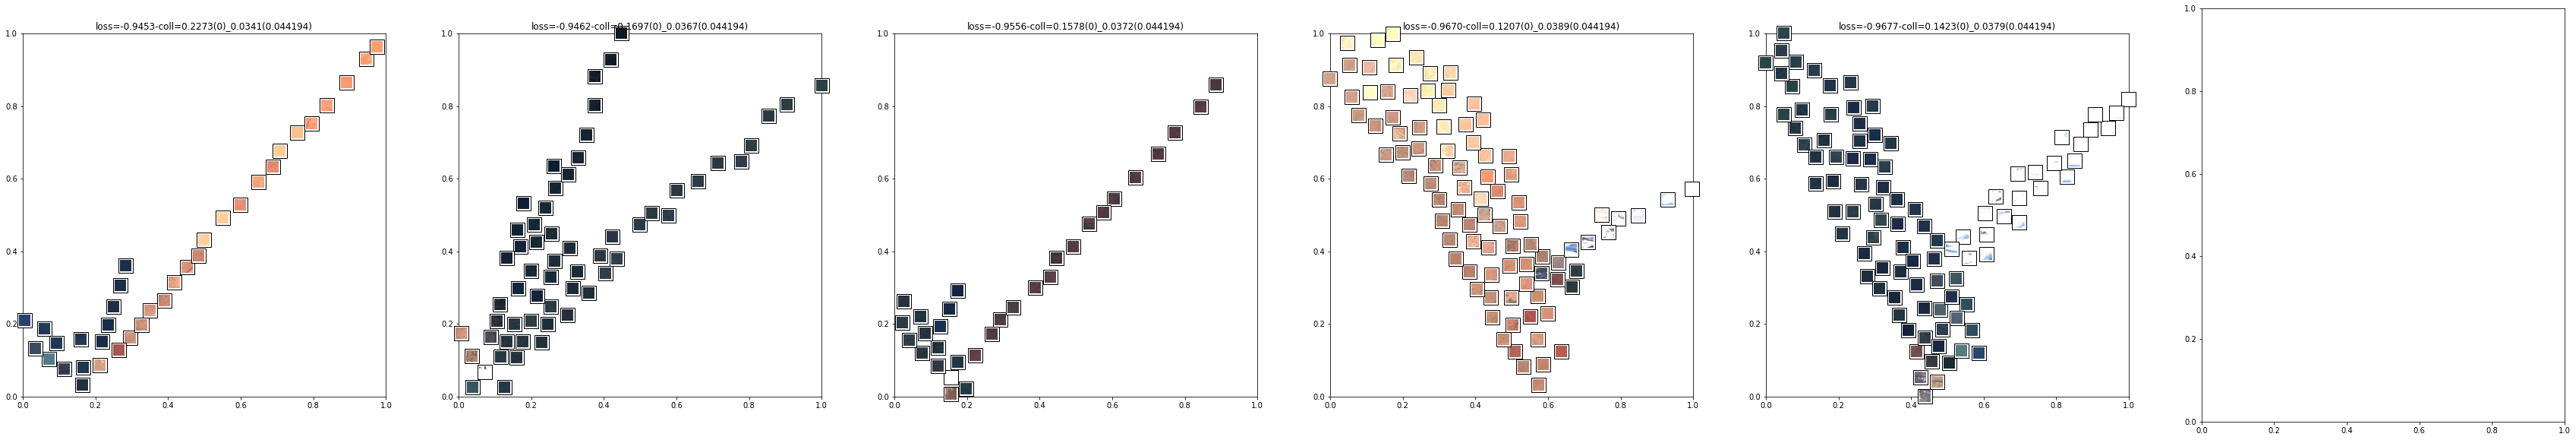

In [28]:
# Validation dataset.
data_dir_test = data_dir_target + '/val/'
print(data_dir_test)

# List of trained models.
model_list = []
for root, dirs, files in os.walk('pytorch_models/simsiam/'):
    for i, filename in enumerate(sorted(files, reverse=False)):
        model_list.append(root + filename)
        # print(f'{i:02}: {filename}')

# Plot setup.
ncols = 6
nrows = int(math.ceil(len(model_list) / ncols))

fig, axes = plt.subplots(nrows=nrows,
                         ncols=ncols,
                         figsize=(10*ncols, 10*nrows))

# Convert the array to 1 dimension.
axes = axes.ravel()

# Main loop over the models.
for model_id, model_name in enumerate(model_list):

    # Load model weights.
    model.backbone.load_state_dict(torch.load(model_name))

    # Empty lists.
    embeddings = []
    filenames = []

    # Disable gradients for faster calculations.
    # Put the model in evaluation mode.
    model.eval()
    with torch.no_grad():
        for i, (x, _, fnames) in enumerate(dataloader_val):

            # Move the images to the GPU.
            x = x.to(device)

            # Embed the images with the pre-trained backbone.
            y = model.backbone(x).flatten(start_dim=1)

            # Store the embeddings and filenames in lists.
            embeddings.append(y)
            filenames = filenames + list(fnames)

    # Concatenate the embeddings and convert to numpy.
    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()

    # For the scatter plot we want to transform the images to a two-dimensional
    # vector space using a random Gaussian projection.
    projection = random_projection.GaussianRandomProjection(n_components=2,
                                                            random_state=SEED)
    embeddings_2d = projection.fit_transform(embeddings)

    # Normalize the embeddings to fit in the [0, 1] square.
    M = np.max(embeddings_2d, axis=0)
    m = np.min(embeddings_2d, axis=0)
    embeddings_2d = (embeddings_2d - m) / (M - m)

    # Get a scatter plot with thumbnail overlays.
    get_scatter_plot_with_thumbnails_axes(axes[model_id],
                                          title=model_name[49:93])

    # Show progress.
    print(f'Subplot of model-{model_id} done!',
          end='\r',
          flush=True)

# Save figure.
fig.savefig(f'models_knn_{datetime.now():%Y_%m_%d_%H_%M_%S}.pdf',
            bbox_inches='tight')

***

***

REVISED UP TO HERE!

# Embeddings for the samples of the test dataset

In [ ]:
# Test dataset.
data_dir_test = data_dir_target + '/test/'
print(data_dir_test)

In [ ]:
# load best model weights
idx = 0
print(model_list[idx])
model.backbone.load_state_dict(torch.load(model_list[idx]))

In [ ]:
# Empty lists.
embeddings = []
filenames = []

# Disable gradients for faster calculations.
# Put the model in evaluation mode.
model.eval()
with torch.no_grad():
    for i, (x, _, fnames) in enumerate(dataloader_test):

        # Move the images to the GPU.
        x = x.to(device)

        # Embed the images with the pre-trained backbone.
        y = model.backbone(x).flatten(start_dim=1)

        # Store the embeddings and filenames in lists.
        embeddings.append(y)
        filenames = filenames + list(fnames)

# Concatenate the embeddings and convert to numpy.
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

***

***

# Scatter Plot

## Imports

In [ ]:
# For plotting.
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# For resizing images to thumbnails.
import torchvision.transforms.functional as functional

# For clustering and 2d representations-
from sklearn import random_projection

## Plot some examples

### Definitions

In [ ]:
# Test data.
data_dir_test = data_dir_target + '/test/'
print(data_dir_test)

In [ ]:
# For the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection.
projection = random_projection.GaussianRandomProjection(n_components=2,
                                                        random_state=SEED)
embeddings_2d = projection.fit_transform(embeddings)

# Normalize the embeddings to fit in the [0, 1] square.
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

In [ ]:
def get_scatter_plot_with_thumbnails():
    """
    Creates a scatter plot with image overlays.

    """

    # Initialize empty figure and add subplot.
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)

    # Shuffle images and find out which images to show.
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:

        # Only show image if it is sufficiently far away from the others.
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # Plot image overlays.
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 10.)
        path = os.path.join(data_dir_test, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # Set aspect ratio.
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')

In [ ]:
# Get a scatter plot with thumbnail overlays.
get_scatter_plot_with_thumbnails()

***

***

# Nearest Neighbors

### Pick up one random sample per class

In [ ]:
# List of subdirectories (classes).
directory_list = []
for root, dirs, files in os.walk(data_dir_test):
    for dirname in sorted(dirs):
        directory_list.append(os.path.join(root, dirname))
        print(dirname)

In [ ]:
# List of files (samples).
example_images = []
for classes in directory_list:
    random_file = np.random.choice(os.listdir(classes))
    path_to_random_file = classes + '/' + random_file
    example_images.append(path_to_random_file[53:])
    print(path_to_random_file)

In [ ]:
def get_image_as_np_array(filename: str):
    """
    Loads the image with filename and returns it as a numpy array.

    """
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """
    Returns an image as a numpy array with a black frame of width w.

    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape

    # Create an empty image with padding for the frame.
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)

    # Put the original image in the middle of the new one.
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_nxn(example_image: str, i: int):
    """
    Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 6

    # Initialize empty figure.
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")

    # Get indexes.
    example_idx = filenames.index(example_image)

    # Get distances to the cluster center.
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()

    # Sort indices by distance to the center.
    nearest_neighbors = np.argsort(distances)[:n_subplots]

    # Show images.
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)

        # Get the corresponding filename.
        fname = os.path.join(data_dir_test, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))

        # Let's disable the axis.
        plt.axis("off")

In [ ]:
# Show example images for each cluster.
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_nxn(example_image, i)